# Temporal dynamics of education by gender

## Introduction

The focus of the analysis is on how the education level of the adult population (16+) in Barcelona has evolved over time and across space by gender, and how this evolution is reflected in the different neighbourhoods of the city. More concretely, we investigate how average education levels for men and women changed between 2000 and 2025 (using data at five-year intervals), whether there are differences between genders, how these levels and their changes are distributed across census sections, and what main “types” of neighbourhoods emerge when classifying sections by level and change in education.

We used two datasets in this study. From the Barcelona City Council open data services ([Open Data BCN](https://opendata-ajuntament.barcelona.cat/data/en/dataset/pad_mdbas_niv-educa-esta_sexe)), we retrieved data on the population of Barcelona aged 16 and over, aggregated by level of education and sex according to the Municipal Register of Inhabitants, at census-section level and administrative units of the city ([BarcelonaCiutat](https://opendata-ajuntament.barcelona.cat/data/ca/dataset/20170706-districtes-barris/resource/e16856a7-b3c0-4c32-a468-cc190cbbf7a9)). This structure allows us to link the data to the corresponding geometries. From available data since 1997 we took six time points (2000, 2005, 2010, 2015, 2020 and 2025), which allows us to construct a longitudinal view of educational change at a fine spatial scale. Each record is georeferenced through official census section identifiers that are consistent with the city’s spatial zoning, enabling the integration of the socio-economic information with detailed geographic boundary data for mapping and spatial analysis.

For the analysis, we applied several preprocessing steps. For each census section and year, we computed a weighted average education level separately for females and males; we then took the mean across all sections to obtain a single city-wide value for each year and sex.


In [ ]:
#Necassary Libraries 
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from shapely import wkt
import numpy as np
from libpysal.weights import Queen
from esda import Moran
from libpysal import graph
import esda
import pandas
from matplotlib.patches import Patch
from sklearn import cluster
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering

In [ ]:
# Data preprocessing
# 1. Loading the data
files = {
    2000: "2000_pad_mdbas_niv-educa-esta_sexe.csv",
    2005: "2005_pad_mdbas_niv-educa-esta_sexe.csv",
    2010: "2010_pad_mdbas_niv-educa-esta_sexe.csv",
    2015: "2015_pad_mdbas_niv-educa-esta_sexe.csv",
    2020: "2020_pad_mdbas_niv-educa-esta_sexe.csv",
    2025: "2025_pad_mdbas_niv-educa-esta_sexe.csv",
}

dfs = []
for year, fname in files.items():
    df = pd.read_csv(fname, sep=",", encoding="latin-1")
    df["year"] = year
    dfs.append(df)

pop_all_years = pd.concat(dfs, ignore_index=True)

pop_all_years["NIV_EDUCA_esta"] = pd.to_numeric(
    pop_all_years["NIV_EDUCA_esta"], errors="coerce"
)
pop_all_years["Valor"] = pd.to_numeric(
    pop_all_years["Valor"], errors="coerce"
).fillna(0)

# 2. Weighted average education by year & sex (long- extended by education level)
group_cols = [
    "year",
    "Seccio_Censal",
    "Codi_Districte",
    "Nom_Districte",
    "Codi_Barri",
    "Nom_Barri",
    "AEB",
]

avg_by_year_sex = (
    pop_all_years
    .groupby(group_cols + ["SEXE"])
    .apply(
        lambda g: (g["NIV_EDUCA_esta"] * g["Valor"]).sum() / g["Valor"].sum()
        if g["Valor"].sum() > 0 else np.nan
    )
    .reset_index(name="avg_edu")
)

# 3. Pivoting sex to columns (avg_edu_male, avg_edu_female)
avg_wide = (
    avg_by_year_sex
    .pivot(index=group_cols, columns="SEXE", values="avg_edu")
    .rename(columns={1:"avg_edu_female", 2: "avg_edu_male"})
    .reset_index()
)
avg_wide.columns.name = None

target_years = [2000, 2005, 2010, 2015, 2020, 2025]
avg_wide = avg_wide[avg_wide["year"].isin(target_years)]

# 4. Pivoting time to columns (avg_edu_male_2000, and for all years.)
avg_wide_clean = avg_wide.drop(columns=["Nom_Barri", "AEB"])

df_wide_time = (
    avg_wide_clean
    .pivot_table(
        index=["Seccio_Censal", "Codi_Districte", "Codi_Barri", "Nom_Districte"],
        columns="year",
        values=["avg_edu_male", "avg_edu_female"]
    )
)

df_wide_time.columns = [f"{metric}_{year}" for metric, year in df_wide_time.columns]
df_wide_time = df_wide_time.reset_index()

# 5. Merging with spatial reference data
Reference_data = pd.read_csv(
    "BarcelonaCiutat_SeccionsCensals.csv", sep=",", encoding="latin-1"
)

# 6. Cleaning Seccio_Censal in df_wide_time to match reference
df_wide_time["Seccio_Censal"] = (
    df_wide_time["Seccio_Censal"]
    .astype(str)
    .str[1:]          # drop first character
    .str.lstrip("0")  # remove leading zeros
)
df_wide_time["Seccio_Censal"] = pd.to_numeric(
    df_wide_time["Seccio_Censal"], errors="coerce"
)

Reference_data = Reference_data.rename(columns={
    "codi_districte": "Codi_Districte",
    "nom_districte": "Nom_Districte",
    "codi_barri": "Codi_Barri",
    "codi_seccio_censal": "Seccio_Censal",
})

Reference_data["Seccio_Censal"] = Reference_data["Seccio_Censal"].astype(int)

merged_data = df_wide_time.merge(
    Reference_data,
    on=["Seccio_Censal", "Codi_Districte", "Codi_Barri"],
    how="left"
)


## The change in education level by gender since 2000

Firstly, we tried to understand how education level of the population has evolved over time and what is the change in degree of education. Figure 1 displays the resulting time series, with one line for male and female. The dataset shows level from 1- to – 6, 1 lowest level, and 6 at highest . 

In [ ]:
df_edu = merged_data
years = [2000, 2005, 2010, 2015, 2020, 2025]

female_means = [df_edu[f'avg_edu_female_{y}'].mean() for y in years]
male_means   = [df_edu[f'avg_edu_male_{y}'].mean()   for y in years]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(years, female_means, marker='o', label='Female')
ax.plot(years, male_means,   marker='o', linestyle='--', label='Male')

ax.set_xlabel('Year')
ax.set_ylabel('Weighted Average of education level')
ax.set_title('Education trends for male and female population aged 16 years old and older')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
#plt.savefig('Figure_1', bbox_inches='tight')
plt.tight_layout()
plt.show()


![Figure_1: Education level change in time](Figure_1.png)

The two trajectories show that the education level has changed substantially over the 25-year period, and that this change has been broadly similar for both genders. Both series follow a clear upward path, indicating that the average level of education in the adult population has increased over time. Given that the education scale ranges from 1 (lowest) to 6 (highest), a city-wide average of around 3.9 in 2025 indicates that Barcelona’s adult population has, on average, moved into the upper half of the education distribution, although it is still some distance from the highest possible level. The key result is the strong improvement from just above 3.0 in 2000 to nearly 3.9 in 2025. Differences between the male and female lines are relatively modest, suggesting that changes in education are not driven exclusively by one gender. Men start at a slightly higher level than women and maintain a small advantage up to around 2020, but the gap gradually narrows. By 2025, the female and male series almost converge at the top of the range, suggesting that not only has the overall education level improved, but gender differences in education have also diminished over time.

These aggregate trends are consistent with other recent evidence on the education system in Catalonia and Barcelona. Access to education beyond compulsory secondary school, particularly vocational and training cycles, has expanded, while early school dropout has fallen to 14.8% among 16–24-year-olds in Catalonia and 7.7% in Barcelona. At the same time, the number of students repeating school years has decreased and graduation rates from compulsory secondary education (ESO) have increased. Implemented school segregation policies contributed to the drop in segregation. Together, these developments help explain the sustained rise in the average education level captured in our data.

## Saptial distribution of overall education level by sex

To examine the spatial pattern of education, we summarised the full time series into a single indicator per census section and sex. For each section, we took the mean of the six yearly averages (2000, 2005, 2010, 2015, 2020 and 2025), separately for women and men. This captures the long-run average education level in each place rather than the situation in a single year. Using the geometric information from the census boundaries, we then mapped these values for all census sections in Barcelona (Figure 2).


In [ ]:
gdf = gpd.GeoDataFrame( merged_data.copy(), geometry=merged_data["geometria_wgs84"].apply(wkt.loads), crs="EPSG:4326")

# Overall average education per census unit
female_columns = [f'avg_edu_female_{y}' for y in years]
male_columns   = [f'avg_edu_male_{y}'   for y in years]

gdf['avg_edu_female_overall'] = gdf[female_cols].mean(axis=1)
gdf['avg_edu_male_overall']   = gdf[male_cols].mean(axis=1)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
gdf.plot(
    column="avg_edu_female_overall",
    cmap="Purples",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    ax=ax1
)
ax1.set_title("Overall average education (Female)")
ax1.set_axis_off()

gdf.plot(
    column="avg_edu_male_overall",
    cmap="Purples",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    ax=ax2
)
ax2.set_title("Overall average education (Male)")
ax2.set_axis_off()


plt.tight_layout()
plt.show()



The maps reveal a clear spatial structure in education. Rather than being randomly scattered, higher and lower average education levels tend to cluster in particular parts of the city. Some areas, possibly those closer to major universities and high-amenity neighbourhoods, display consistently higher average levels for both women and men across the entire period, while others remain persistently lower. People with higher education are more likely to choose to live in these high-education areas, and their choices are mediated by the housing market, dwelling quality, local amenities and school quality; however, this mechanism would need to be confirmed with supplementary data. Visually, the pattern for women and men is broadly similar, although local differences appear in some neighbourhoods where one gender slightly outperforms the other. Overall, these maps make visible the spatial inequalities in education that underlie the aggregate time series: even though the city as a whole has improved, not all census sections share the same starting point or long-run position.

## Percentage change in average education (2000–2025)

To complement the view based on levels, we also examine how strongly each census section has changed over time. For this, we computed the percentage change in average education between 2000 and 2025 separately for women and men. The resulting indicators capture how much education has improved (or, in a few cases, deteriorated) over the 25-year period relative to the initial situation. Figure 3 maps these percentage changes for women and men using a common colour scale. 

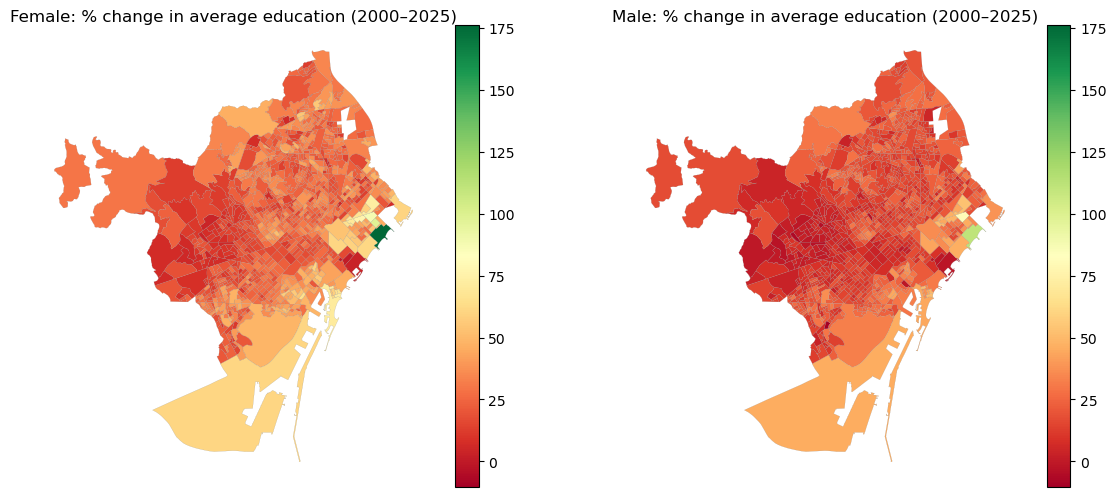

In [124]:
gdf["pct_edu_female_2000_2025"] = ((gdf["avg_edu_female_2025"] - gdf["avg_edu_female_2000"]) / gdf["avg_edu_female_2000"].replace(0, np.nan) * 100 )
gdf["pct_edu_male_2000_2025"] = ((gdf["avg_edu_male_2025"] - gdf["avg_edu_male_2000"]) / gdf["avg_edu_male_2000"].replace(0, np.nan) * 100)

M_F = gdf[["pct_edu_female_2000_2025", "pct_edu_male_2000_2025"]]

vmin, vmax = M_F.min().min(), M_F.max().max()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

gdf.plot(
    column="pct_edu_female_2000_2025",
    cmap="RdYlGn",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    vmin=vmin,
    vmax=vmax,
    ax=ax1,
)
ax1.set_title("Female: % change in average education (2000–2025)")
ax1.set_axis_off()

gdf.plot(
    column="pct_edu_male_2000_2025",
    cmap="RdYlGn",
    linewidth=0.1,
    edgecolor="grey",
    legend=True,
    vmin=vmin,
    vmax=vmax,
    ax=ax2,
)
ax2.set_title("Male: % change in average education (2000–2025)")
ax2.set_axis_off()



The maps show that the dynamics of change are far from spatially uniform. Most census sections register positive growth in education, but the magnitude of this growth varies substantially across the city. Some areas, particularly in parts of the coastal and peripheral districts, exhibit very large relative increases (the green tones), while others experience more moderate gains or almost no change (orange and red tones). These strong percentage increases often occur in sections that started from relatively low education levels in 2000, so even a moderate absolute improvement translates into a large relative change. They may also reflect neighbourhoods that have undergone urban renewal, especially the Sant Martí district, shown in dark green in the figure, which has experienced substantial regeneration since 2000, or that have attracted new, more highly educated residents over the period, for example through regeneration projects, changes in the housing market, or improved transport connections. By contrast, several central or already highly educated areas show smaller percentage increases, consistent with having less “room” for further gains.

Comparing the female and male maps suggests that, in most places, improvements have been broadly shared across genders: sections with strong increases for women typically also show strong increases for men. Nonetheless, there are local pockets where the change is slightly stronger for one gender, hinting at subtle differences in how educational expansion has affected women and men. Taken together with the level maps, these results indicate that some neighbourhoods are both highly educated and improving, while others remain doubly disadvantaged, combining lower starting levels with weaker growth.


## Spatial autocorrelation based on overall education level by sex

The choropleth maps above suggest that education is spatially clustered: neighbouring census sections tend to look similar. To assess this more formally, we computed measures of local spatial autocorrelation (Local Moran’s I) for the overall average education of women and men. We first defined a spatial neighborhood structure using queen contiguity, where two census sections are considered neighbors if they share any part of their boundary (edge or corner). This produces a spatial weights matrix that encodes who is “close to whom”. After row-standardizing this matrix (so each row sums to one), we applied esda.Moran_Local separately to the female and male overall averages (shown in Figure 4). Using a 5% significance threshold, we grouped each section into one of five cluster types: High–High (high education surrounded by high), Low–Low (low surrounded by low), High–Low, Low–High, or Insignificant (no significant local pattern).

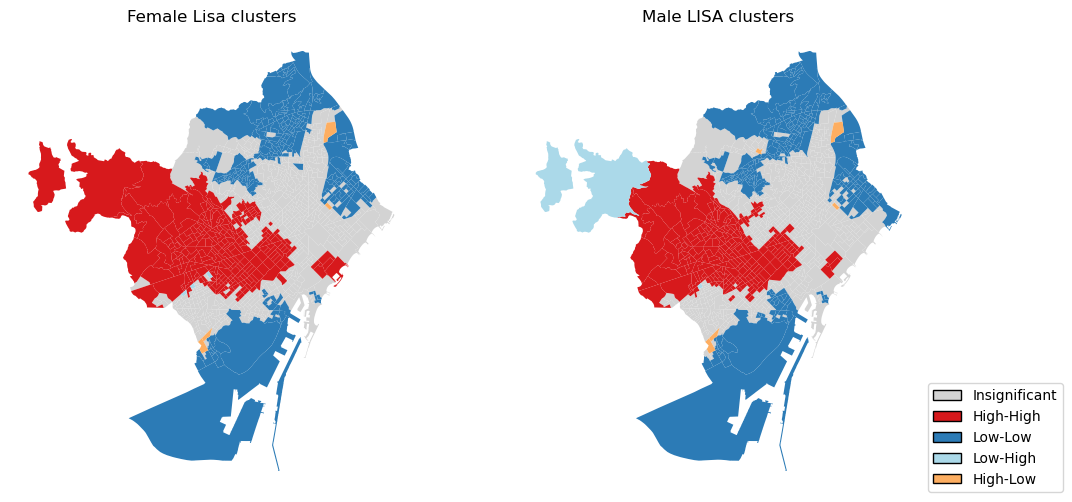

In [125]:
contiguity = graph.Graph.build_contiguity(gdf, rook=False) 
contiguity_r = contiguity.transform("r")

lisa_F = esda.Moran_Local(gdf['avg_edu_female_overall'], contiguity_r)
lisa_M = esda.Moran_Local(gdf['avg_edu_male_overall'], contiguity_r)

gdf['cluster_F'] = lisa_F.get_cluster_labels(crit_value=0.05)
gdf['cluster_M'] = lisa_M.get_cluster_labels(crit_value=0.05)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

gdf.loc[gdf["cluster_F"] == "Insignificant"].plot(ax=ax1, color="lightgrey")
gdf.loc[gdf["cluster_F"] == "High-High"].plot(ax=ax1, color="#d7191c")
gdf.loc[gdf["cluster_F"] == "Low-Low"].plot(ax=ax1, color="#2c7bb6")
gdf.loc[gdf["cluster_F"] == "Low-High"].plot(ax=ax1, color="#abd9e9")
gdf.loc[gdf["cluster_F"] == "High-Low"].plot(ax=ax1, color="#fdae61")

ax1.set_title("Female Lisa clusters")
ax1.set_axis_off()

gdf.loc[gdf["cluster_M"] == "Insignificant"].plot(ax=ax2, color="lightgrey")
gdf.loc[gdf["cluster_M"] == "High-High"].plot(ax=ax2, color="#d7191c")
gdf.loc[gdf["cluster_M"] == "Low-Low"].plot(ax=ax2, color="#2c7bb6")
gdf.loc[gdf["cluster_M"] == "Low-High"].plot(ax=ax2, color="#abd9e9")
gdf.loc[gdf["cluster_M"] == "High-Low"].plot(ax=ax2, color="#fdae61")
ax2.set_title("Male LISA clusters")
ax2.set_axis_off()

legend_elements = [
    Patch(facecolor="lightgrey", edgecolor="black", label="Insignificant"),
    Patch(facecolor="#d7191c", edgecolor="black", label="High-High"),
    Patch(facecolor="#2c7bb6", edgecolor="black", label="Low-Low"),
    Patch(facecolor="#abd9e9", edgecolor="black", label="Low-High"),
    Patch(facecolor="#fdae61", edgecolor="black", label="High-Low"),
]

ax2.legend(
    handles=legend_elements,
    loc="lower left",
    bbox_to_anchor=(1.02, 0),  
    ncol=1,
    borderaxespad=0.
)



The maps confirm that educational levels are strongly clustered in Barcelona. High-education clusters (red) dominate much of the western and south-western parts of the city and appear in a few additional pockets, indicating large contiguous areas of advantage. In contrast, low-education clusters (dark blue) are mainly concentrated in the northern and north-eastern periphery, where educational disadvantage is more persistent. A smaller number of sections fall into the mixed categories (yellow and light blue), marking sharp local contrasts along the boundaries between these high- and low-education zones, while grey areas show no clear local pattern.

Overall, the patterns for women and men are broadly similar: the main High–High and Low–Low regions overlap for both sexes, indicating that the spatial processes shaping education, such as residential sorting, housing markets or school catchment areas, tend to affect women and men simultaneously. There are, however, some local differences in cluster type, especially along certain boundaries between advantaged and disadvantaged areas, suggesting that gendered dynamics may play a role in a few specific neighborhoods. Together, these results show a strong degree of spatial autocorrelation in education: where you live in Barcelona is closely related to the long-run education level of both women and men in your census section and its neighbors.



## Clustering Barcelona’s Census Sections by Educational Profiles

To move from continuous indicators to a more interpretable typology of neighbourhoods, we created a classification of Barcelona’s census sections based on their educational characteristics. Specifically, we focused on four features: the overall average education for women and for men and the percentage change in average education between 2000 and 2025 for women and men. Before clustering, we standardized these variables to have mean zero and unit variance, so that no single indicator dominated the solution purely because of its scale.
We then applied k-means clustering with four clusters to the standardized feature matrix, using each census section as an observation. The resulting cluster labels were joined back to the GeoDataFrame and mapped in Figure 5, a classification of Barcelona’s neighbourhoods into four types, defined jointly by long-run education levels and long-term educational change for both women and men.


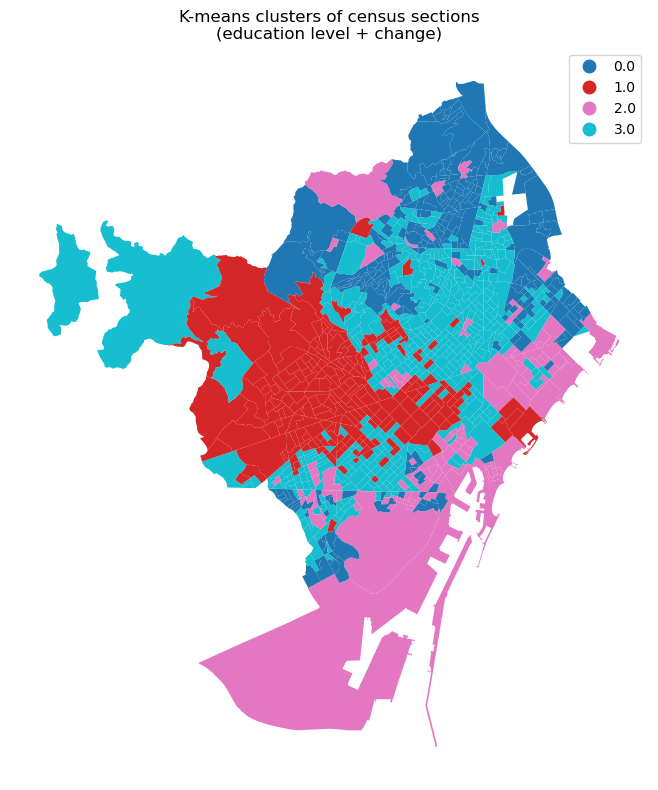

In [122]:
clustering_features = [
    "avg_edu_female_overall",
    "avg_edu_male_overall",
    "pct_edu_female_2000_2025",
    "pct_edu_male_2000_2025",
]

X_df = (
    gdf[clustering_features]
    .astype(float)                               
    .replace([np.inf, -np.inf], np.nan)        
    .dropna(axis=0, how="any")                  
)
g_clust = gdf.loc[X_df.index].copy()
X = X_df.values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans.fit(X_scaled)
g_clust["cluster_km"] = kmeans.labels_

gdf.loc[g_clust.index, "cluster_km"] = g_clust["cluster_km"]
agg = AgglomerativeClustering(n_clusters=4)
labels = agg.fit_predict(X_scaled)
gdf.loc[X_df.index, "cluster_agglom"] = labels

fig, ax = plt.subplots(figsize=(8, 8))
gdf.plot(column="cluster_km", categorical=True, legend=True, ax=ax)
ax.set_title("K-means clusters of census sections\n(education level + change)")
ax.set_axis_off()
plt.tight_layout()
plt.show()


Inspecting the cluster-wise averages of the four input variables reveals clear differences across groups. Cluster 1 contains census sections with the highest overall education levels for both women and men (around 4.0 and 4.2 on a 1–6 scale) and only modest percentage gains over time; these can be interpreted as advantaged and consolidating neighborhoods. Cluster 0 combines the lowest overall education (around 3.0–3.1) with only moderate growth, representing persistently disadvantaged areas that remain clearly below the city average. Cluster 2 has medium education levels (around 3.3–3.4) but the strongest percentage increases, especially for women (over 50% on average), resembling upgrading neighborhoods that are catching up from a lower starting point. Cluster 3, the largest group, occupies an intermediate position, with moderate levels (around 3.5–3.7) and moderate changes, and can be seen as stable middle-range sections.

The main types of neighborhoods we identify are therefore distinguished by two key characteristics: their long-run educational position (high vs low average education) and their educational trajectory over the period (fast vs slow improvement), with gender differences implicitly taken into account through the inclusion of both male and female indicators. If this classification were to be used to target areas in most need, the natural priority would be the cluster combining low overall education and relatively weak growth (Cluster 0), since these neighborhoods both lag behind the city and show limited signs of catching up. A secondary priority could be the upgrading cluster (Cluster 2), where education levels are still moderate but improvements are strong, and where additional support might consolidate and accelerate ongoing progress.

In spatial terms, high-education, relatively stable census sections (Cluster 1) tend to concentrate in particular parts of Barcelona, while low-education, slow-growing clusters (Cluster 0) form more continuous areas elsewhere. Upgrading neighborhoods (Cluster 2) often appear adjacent to more advantaged zones, suggesting possible spillovers or diffusion of educational gains across local boundaries. The resulting classification therefore not only summarizes complex temporal and gendered dynamics into a small number of meaningful types, but also highlights how educational inequality and change are organized in space across Barcelona’s urban fabric.

